[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)


# Chain

## Review(復習)

前回は、ノード、通常エッジ、条件付きエッジを使用してシンプルなグラフを作成しました。

## Goals

次に、4 つの[概念](https://python.langchain.com/v0.3/docs/concepts/)を組み合わせたシンプルなチェーンを作成してみましょう。

- [チャットメッセージ](https://python.langchain.com/v0.3/docs/concepts/#messages) をグラフの状態として使用する
- [チャットモデル](https://python.langchain.com/v0.3/docs/concepts/#chat-models) をグラフノードで使用する
- [バインディングツール](https://python.langchain.com/v0.3/docs/concepts/#tools) をチャットモデルに適用
- グラフノードで[ツール呼び出しを実行](https://python.langchain.com/v0.3/docs/concepts/#functiontool-calling)

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)


In [1]:
# uv を使っている場合は特にインストール不要
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Messages

チャットモデルは [`messages`](https://python.langchain.com/v0.3/docs/concepts/#messages) を使用でき、会話内のさまざまな役割を担います。

LangChain は、`HumanMessage`、`AIMessage`、`SystemMessage`、`ToolMessage` など、さまざまなメッセージタイプをサポートしています。

これらは、ユーザーからのメッセージ、チャットモデルからのメッセージ、チャットモデルが動作を指示するためのメッセージ、ツール呼び出しからのメッセージを表します。

メッセージのリストを作成してみましょう。

各メッセージには、いくつかの情報を付与することができます。

- `content` - メッセージの内容
- `name` - 追加任意。メッセージの送信者
- `response_metadata` - 追加任意。メタデータの辞書(例えば、モデルプロバイダが `AIMessages` 用に用意することが多い)


In [6]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content="海洋哺乳類の研究をされているのですか？", name="Model")]
messages.append(HumanMessage(content="はい、そうです。", name="Lance"))
messages.append(AIMessage(content="いいですね、何について学びたいですか？", name="Model"))
messages.append(HumanMessage(content="アメリカでシャチを見るのに最適な場所について知りたいです。", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

海洋哺乳類の研究をされているのですか？
================================ Human Message =================================
Name: Lance

はい、そうです。
================================== Ai Message ==================================
Name: Model

いいですね、何について学びたいですか？
================================ Human Message =================================
Name: Lance

アメリカでシャチを見るのに最適な場所について知りたいです。


## Chat Models

[チャットモデル](https://python.langchain.com/v0.2/docs/concepts/#chat-models) は、メッセージのシーケンスを入力として使用し、前述のとおり、メッセージタイプをサポートすることができます。

選択肢はたくさんあります(https://python.langchain.com/v0.2/docs/concepts/#chat-models)。OpenAIで作業してみましょう。

`OPENAI_API_KEY` が設定されていることを確認し、設定されていない場合は入力するように求められます。

注意: リンクは langchain v0.2 のドキュメントにリンクしているものの、poetry で環境を作ると langchain v0.3 を使用しているはずです。


In [7]:
import os
import getpass


def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

チャットモデルを読み込んで、メッセージの一覧を表示せずに呼び出すことができます。

その結果は、特定の `response_metadata` を持つ `AIMessage` であることがわかります。


In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [9]:
result

AIMessage(content='アメリカでシャチを見るのに最適な場所はいくつかあります。特に以下の地域が人気です：\n\n1. **ワシントン州のオリンピック半島** - 特にサンファン諸島周辺はシャチの観察スポットとして有名です。夏の間、特に6月から9月にかけて、南方のオルカ（シャチ）がよく見られます。\n\n2. **アラスカ** - アラスカの沿岸部もシャチの観察に適しています。クルーズやボートツアーを利用すると、シャチを見るチャンスが増えます。\n\n3. **カリフォルニア州のモントレー湾** - モントレー湾は多様な海洋生物が生息しており、シャチも見られることがあります。特に春から秋にかけてが見頃です。\n\n4. **フロリダ州のエバーグレーズ** - バイソンやワニと共に、シャチが見られることもありますが、主に他の海洋生物の観察がメインとなることが多いです。\n\nこれらの地域では、観察ツアーを提供している会社がたくさんありますので、事前に予約して参加するのが良いでしょう。また、シャチは野生動物なので、観察できるかどうかは運次第ですが、これらの場所では高い確率で出会える可能性があります。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 346, 'prompt_tokens': 78, 'total_tokens': 424, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_482c22a7bc', 'finish_reason': 'stop', 'logprobs': None}, id='run-917ca063-6ea8-4ec4-b6de-e4ed86602750-0', usage_metadata={'input_toke

In [10]:
result.response_metadata

{'token_usage': {'completion_tokens': 346,
  'prompt_tokens': 78,
  'total_tokens': 424,
  'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_482c22a7bc',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

モデルに外部システムとやり取りさせたい場合には、Tool が便利です。

外部システム(API など)では、自然言語よりも特定の入力スキーマやペイロードを必要とする場合がよくあります。

たとえば、API を tool としてバインドすると、モデルに必要な入力スキーマを認識させることができます。

モデルは、ユーザーが入力した自然言語に基づいて tool を呼び出すことを選択します。

そして、tool のスキーマに従った出力を返します。

[多くの LLM プロバイダーがツール呼び出しをサポートしています](https://python.langchain.com/v0.3/docs/integrations/chat/)し、LangChain のツール呼び出しインターフェースはシンプルです。

Python の任意の`関数`を、`ChatModel.bind_tools(function)`に渡すだけでよいのです。

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)


ツール呼び出し(tool calling)の簡単な例を見てみましょう!

`multiply` 関数が私たちの tool です。


In [11]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


llm_with_tools = llm.bind_tools([multiply])

例えば「2 に 3 を掛けると何になるか」のような入力値を渡すと、ツール呼び出しが返されます。

ツール呼び出しには、呼び出す関数の名前とともに、関数の入力スキーマに一致する引数が含まれています。

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```


In [12]:
tool_call = llm_with_tools.invoke([HumanMessage(content="2掛ける3はいくつになりますか", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Pfo7Eb9ePatpmnwFzXCYCO0U', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 64, 'total_tokens': 81, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_482c22a7bc', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3f5ecabb-061a-4c7e-8959-d9e9256004f0-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_Pfo7Eb9ePatpmnwFzXCYCO0U', 'type': 'tool_call'}], usage_metadata={'input_tokens': 64, 'output_tokens': 17, 'total_tokens': 81, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [13]:
tool_call.additional_kwargs["tool_calls"]

[{'id': 'call_Pfo7Eb9ePatpmnwFzXCYCO0U',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

## メッセージを state として使用

これらの基礎が整ったので、今度はグラフの状態に [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) を使用します。

状態 `MessagesState` を、単一のキー `messages` を持つ `TypedDict` として定義してみましょう。

`messages` は、上で定義したように(例えば、`HumanMessage` など)単にメッセージのリストです。

注意: リンクは langchain v0.2 のドキュメントにリンクしているものの、poetry で環境を作ると langchain v0.3 を使用しているはずです。


In [14]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage


class MessagesState(TypedDict):
    # この定義だと、毎回上書きされる
    messages: list[AnyMessage]

## Reducers

さて、ちょっとした問題が発生しました!

先ほど説明したように、各ノードは状態キー `messages` に新しい値を返します。

しかし、この新しい値は以前の `messages` の値を [上書き](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) します。

グラフが実行されると、私たちは `messages` 状態キーにメッセージを **追加** したいのです。

これには [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) を使用できます。

reducer を使用することで、state の更新方法を指定することができます。

reducer 関数が指定されていない場合、以前にも見たように、キーへの更新はそれを **上書きする** ものと想定されます。

しかし、メッセージを追加するには、あらかじめ用意されている `add_messages` reducer を使用できます。

これにより、すべてのメッセージが既存のメッセージのリストに追加されることが保証されます。

私たちは、`messages` キーに `add_messages` reducer 関数をメタデータとしてアノテーションするだけでよいのです。


In [15]:
from typing import Annotated
from langgraph.graph.message import add_messages


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

メッセージのリストがグラフの状態であることはよくあるので、LangGraph にはあらかじめ構築された[`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)があります!

`MessagesState` は次のように定義されています。

- 事前に構築された単一の `messages` キーを含む。
- `AnyMessage` オブジェクトのリストです。
- `add_messages` リダクタを使用します。

通常は、上記のカスタム `TypedDict` を定義するよりも簡潔であるため、`MessagesState` を使用します。


In [16]:
from langgraph.graph import MessagesState


class MessagesState(MessagesState):
    # メッセージ以外に必要なキーを追加します。これはあらかじめ構築されています。
    pass

もう少し深く掘り下げるために、`add_messages` reducer が単独でどのように動作するのかを見てみましょう。


In [17]:
# Initial state
initial_messages = [
    AIMessage(content="なにかお手伝いできることはありますか?", name="Model"),
    HumanMessage(content="海洋生物学の情報を探しています。", name="Lance"),
]

# New message to add
new_message = AIMessage(content="わかりました。具体的にはどのようなことにご興味がありますか？", name="Model")

# Test
add_messages(left=initial_messages, right=new_message)

[AIMessage(content='なにかお手伝いできることはありますか?', additional_kwargs={}, response_metadata={}, name='Model', id='60c2aae3-169e-40cb-bf3e-d38261388e4a'),
 HumanMessage(content='海洋生物学の情報を探しています。', additional_kwargs={}, response_metadata={}, name='Lance', id='c3689252-1bc0-4c3b-8e75-646517b8fd32'),
 AIMessage(content='わかりました。具体的にはどのようなことにご興味がありますか？', additional_kwargs={}, response_metadata={}, name='Model', id='8cb096e2-0f55-4f3e-950c-a6063e52e457')]

## Our graph

それでは、`MessagesState` をグラフで使用してみましょう


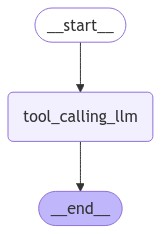

In [18]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage


# Node
def tool_calling_llm(state: MessagesState) -> dict[str, list[BaseMessage]]:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

`Hello!` を渡すと、LLM はツール呼び出しなしで応答します。


In [19]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


LLM は、入力またはタスクがそのツールが提供する機能が必要であると判断した場合に、そのツールを使用することを選択します。


In [20]:
messages = graph.invoke({"messages": HumanMessage(content="2掛ける3")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

2掛ける3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Ebpowk0sF2rV02SPyxcF59iO)
 Call ID: call_Ebpowk0sF2rV02SPyxcF59iO
  Args:
    a: 2
    b: 6
